In [1]:
from collections import namedtuple

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim

import scipy.misc
import matplotlib.pyplot as plt

## Bileaner Sampler

In [2]:
def bilinear_sampler_1d_h(input_images, x_offset, wrap_mode='border', name='bilinear_sampler', **kwargs):
    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.tile(tf.expand_dims(x, 1), [1, n_repeats])
            return tf.reshape(rep, [-1])

    def _interpolate(im, x, y):
        with tf.variable_scope('_interpolate'):

            # handle both texture border types
            _edge_size = 0
            if _wrap_mode == 'border':
                _edge_size = 1
                im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
                x = x + _edge_size
                y = y + _edge_size
            elif _wrap_mode == 'edge':
                _edge_size = 0
            else:
                return None

            x = tf.clip_by_value(x, 0.0,  _width_f - 1 + 2 * _edge_size)

            x0_f = tf.floor(x)
            y0_f = tf.floor(y)
            x1_f = x0_f + 1

            x0 = tf.cast(x0_f, tf.int32)
            y0 = tf.cast(y0_f, tf.int32)
            x1 = tf.cast(tf.minimum(x1_f,  _width_f - 1 + 2 * _edge_size), tf.int32)

            dim2 = (_width + 2 * _edge_size)
            dim1 = (_width + 2 * _edge_size) * (_height + 2 * _edge_size)
            base = _repeat(tf.range(_num_batch) * dim1, _height * _width)
            base_y0 = base + y0 * dim2
            idx_l = base_y0 + x0
            idx_r = base_y0 + x1

            im_flat = tf.reshape(im, tf.stack([-1, _num_channels]))

            pix_l = tf.gather(im_flat, idx_l)
            pix_r = tf.gather(im_flat, idx_r)

            weight_l = tf.expand_dims(x1_f - x, 1)
            weight_r = tf.expand_dims(x - x0_f, 1)

            return weight_l * pix_l + weight_r * pix_r

    def _transform(input_images, x_offset):
        with tf.variable_scope('transform'):
            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            x_t, y_t = tf.meshgrid(tf.linspace(0.0,   _width_f - 1.0,  _width),
                                   tf.linspace(0.0 , _height_f - 1.0 , _height))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            x_t_flat = tf.tile(x_t_flat, tf.stack([_num_batch, 1]))
            y_t_flat = tf.tile(y_t_flat, tf.stack([_num_batch, 1]))

            x_t_flat = tf.reshape(x_t_flat, [-1])
            y_t_flat = tf.reshape(y_t_flat, [-1])

            x_t_flat = x_t_flat + tf.reshape(x_offset, [-1]) * _width_f

            input_transformed = _interpolate(input_images, x_t_flat, y_t_flat)

            output = tf.reshape(
                input_transformed, tf.stack([_num_batch, _height, _width, _num_channels]))
            return output

    with tf.variable_scope(name):
        _num_batch    = tf.shape(input_images)[0]
        _height       = tf.shape(input_images)[1]
        _width        = tf.shape(input_images)[2]
        _num_channels = tf.shape(input_images)[3]

        _height_f = tf.cast(_height, tf.float32)
        _width_f  = tf.cast(_width,  tf.float32)

        _wrap_mode = wrap_mode

        output = _transform(input_images, x_offset)
        return output

## monodepth_model.py

In [8]:
class MonodepthModel(object):
    """monodepth model"""

    def __init__(self, params, mode, left, right, reuse_variables=None, model_index=0):
        self.params = params
        self.mode = mode
        self.left = left
        self.right = right
        self.model_collection = ['model_' + str(model_index)]

        self.reuse_variables = reuse_variables

        self.build_model()
        self.build_outputs()

        if self.mode == 'test':
            return

        self.build_losses()
        self.build_summaries()     

    def gradient_x(self, img):
        gx = img[:,:,:-1,:] - img[:,:,1:,:]
        return gx

    def gradient_y(self, img):
        gy = img[:,:-1,:,:] - img[:,1:,:,:]
        return gy

    def upsample_nn(self, x, ratio):
        s = tf.shape(x)
        h = s[1]
        w = s[2]
        return tf.image.resize_nearest_neighbor(x, [h * ratio, w * ratio])
  
    def scale_pyramid(self, img, num_scales):
        scaled_imgs = [img]
        s = tf.shape(img)
        h = s[1]
        w = s[2]
        for i in range(num_scales - 1):
            ratio = 2 ** (i + 1)
            nh = h // ratio
            nw = w // ratio
            scaled_imgs.append(tf.image.resize_area(img, [nh, nw]))
        return scaled_imgs

    def generate_image_left(self, img, disp):
        return bilinear_sampler_1d_h(img, -disp)

    def generate_image_right(self, img, disp):
        return bilinear_sampler_1d_h(img, disp)

    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = slim.avg_pool2d(x, 3, 1, 'VALID')
        mu_y = slim.avg_pool2d(y, 3, 1, 'VALID')

        sigma_x  = slim.avg_pool2d(x ** 2, 3, 1, 'VALID') - mu_x ** 2
        sigma_y  = slim.avg_pool2d(y ** 2, 3, 1, 'VALID') - mu_y ** 2
        sigma_xy = slim.avg_pool2d(x * y , 3, 1, 'VALID') - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

        SSIM = SSIM_n / SSIM_d

        return tf.clip_by_value((1 - SSIM) / 2, 0, 1)

    def get_disparity_smoothness(self, disp, pyramid):
        disp_gradients_x = [self.gradient_x(d) for d in disp]
        disp_gradients_y = [self.gradient_y(d) for d in disp]

        image_gradients_x = [self.gradient_x(img) for img in pyramid]
        image_gradients_y = [self.gradient_y(img) for img in pyramid]

        weights_x = [tf.exp(-tf.reduce_mean(tf.abs(g), 3, keep_dims=True)) for g in image_gradients_x]
        weights_y = [tf.exp(-tf.reduce_mean(tf.abs(g), 3, keep_dims=True)) for g in image_gradients_y]

        smoothness_x = [disp_gradients_x[i] * weights_x[i] for i in range(4)]
        smoothness_y = [disp_gradients_y[i] * weights_y[i] for i in range(4)]
        return smoothness_x + smoothness_y

    def get_disp(self, x):
        disp = 0.3 * self.conv(x, 2, 3, 1, tf.nn.sigmoid)
        return disp

    def conv(self, x, num_out_layers, kernel_size, stride, activation_fn=tf.nn.elu):
        p = np.floor((kernel_size - 1) / 2).astype(np.int32)
        p_x = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]])
        return slim.conv2d(p_x, num_out_layers, kernel_size, stride, 'VALID', activation_fn=activation_fn)

    def conv_block(self, x, num_out_layers, kernel_size):
        conv1 = self.conv(x,     num_out_layers, kernel_size, 1)
        conv2 = self.conv(conv1, num_out_layers, kernel_size, 2)
        return conv2

    def maxpool(self, x, kernel_size):
        p = np.floor((kernel_size - 1) / 2).astype(np.int32)
        p_x = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]])
        return slim.max_pool2d(p_x, kernel_size)

    def resconv(self, x, num_layers, stride):
        do_proj = tf.shape(x)[3] != num_layers or stride == 2
        shortcut = []
        conv1 = self.conv(x,         num_layers, 1, 1)
        conv2 = self.conv(conv1,     num_layers, 3, stride)
        conv3 = self.conv(conv2, 4 * num_layers, 1, 1, None)
        if do_proj:
            shortcut = self.conv(x, 4 * num_layers, 1, stride, None)
        else:
            shortcut = x
        return tf.nn.elu(conv3 + shortcut)

    def resblock(self, x, num_layers, num_blocks):
        out = x
        for i in range(num_blocks - 1):
            out = self.resconv(out, num_layers, 1)
        out = self.resconv(out, num_layers, 2)
        return out

    def upconv(self, x, num_out_layers, kernel_size, scale):
        upsample = self.upsample_nn(x, scale)
        conv = self.conv(upsample, num_out_layers, kernel_size, 1)
        return conv

    def deconv(self, x, num_out_layers, kernel_size, scale):
        p_x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]])
        conv = slim.conv2d_transpose(p_x, num_out_layers, kernel_size, scale, 'SAME')
        return conv[:,3:-1,3:-1,:]

    def build_vgg(self):
        #set convenience functions
        conv = self.conv
        if self.params.use_deconv:
            upconv = self.deconv
        else:
            upconv = self.upconv

        with tf.variable_scope('encoder'):
            conv1 = self.conv_block(self.model_input,  32, 7) # H/2
            conv2 = self.conv_block(conv1,             64, 5) # H/4
            conv3 = self.conv_block(conv2,            128, 3) # H/8
            conv4 = self.conv_block(conv3,            256, 3) # H/16
            conv5 = self.conv_block(conv4,            512, 3) # H/32
            conv6 = self.conv_block(conv5,            512, 3) # H/64
            conv7 = self.conv_block(conv6,            512, 3) # H/128

        with tf.variable_scope('skips'):
            skip1 = conv1
            skip2 = conv2
            skip3 = conv3
            skip4 = conv4
            skip5 = conv5
            skip6 = conv6

        with tf.variable_scope('decoder'):
            upconv7 = upconv(conv7,  512, 3, 2) #H/64
            concat7 = tf.concat([upconv7, skip6], 3)
            iconv7  = conv(concat7,  512, 3, 1)

            upconv6 = upconv(iconv7, 512, 3, 2) #H/32
            concat6 = tf.concat([upconv6, skip5], 3)
            iconv6  = conv(concat6,  512, 3, 1)

            upconv5 = upconv(iconv6, 256, 3, 2) #H/16
            concat5 = tf.concat([upconv5, skip4], 3)
            iconv5  = conv(concat5,  256, 3, 1)

            upconv4 = upconv(iconv5, 128, 3, 2) #H/8
            concat4 = tf.concat([upconv4, skip3], 3)
            iconv4  = conv(concat4,  128, 3, 1)
            self.disp4 = self.get_disp(iconv4)
            udisp4  = self.upsample_nn(self.disp4, 2)

            upconv3 = upconv(iconv4,  64, 3, 2) #H/4
            concat3 = tf.concat([upconv3, skip2, udisp4], 3)
            iconv3  = conv(concat3,   64, 3, 1)
            self.disp3 = self.get_disp(iconv3)
            udisp3  = self.upsample_nn(self.disp3, 2)

            upconv2 = upconv(iconv3,  32, 3, 2) #H/2
            concat2 = tf.concat([upconv2, skip1, udisp3], 3)
            iconv2  = conv(concat2,   32, 3, 1)
            self.disp2 = self.get_disp(iconv2)
            udisp2  = self.upsample_nn(self.disp2, 2)

            upconv1 = upconv(iconv2,  16, 3, 2) #H
            concat1 = tf.concat([upconv1, udisp2], 3)
            iconv1  = conv(concat1,   16, 3, 1)
            self.disp1 = self.get_disp(iconv1)

    def build_resnet50(self):
        #set convenience functions
        conv   = self.conv
        if self.params.use_deconv:
            upconv = self.deconv
        else:
            upconv = self.upconv

        with tf.variable_scope('encoder'):
            conv1 = conv(self.model_input, 64, 7, 2) # H/2  -   64D
            pool1 = self.maxpool(conv1,           3) # H/4  -   64D
            conv2 = self.resblock(pool1,      64, 3) # H/8  -  256D
            conv3 = self.resblock(conv2,     128, 4) # H/16 -  512D
            conv4 = self.resblock(conv3,     256, 6) # H/32 - 1024D
            conv5 = self.resblock(conv4,     512, 3) # H/64 - 2048D

        with tf.variable_scope('skips'):
            skip1 = conv1
            skip2 = pool1
            skip3 = conv2
            skip4 = conv3
            skip5 = conv4
        
        # DECODING
        with tf.variable_scope('decoder'):
            upconv6 = upconv(conv5,   512, 3, 2) #H/32
            concat6 = tf.concat([upconv6, skip5], 3)
            iconv6  = conv(concat6,   512, 3, 1)

            upconv5 = upconv(iconv6, 256, 3, 2) #H/16
            concat5 = tf.concat([upconv5, skip4], 3)
            iconv5  = conv(concat5,   256, 3, 1)

            upconv4 = upconv(iconv5,  128, 3, 2) #H/8
            concat4 = tf.concat([upconv4, skip3], 3)
            iconv4  = conv(concat4,   128, 3, 1)
            self.disp4 = self.get_disp(iconv4)
            udisp4  = self.upsample_nn(self.disp4, 2)

            upconv3 = upconv(iconv4,   64, 3, 2) #H/4
            concat3 = tf.concat([upconv3, skip2, udisp4], 3)
            iconv3  = conv(concat3,    64, 3, 1)
            self.disp3 = self.get_disp(iconv3)
            udisp3  = self.upsample_nn(self.disp3, 2)

            upconv2 = upconv(iconv3,   32, 3, 2) #H/2
            concat2 = tf.concat([upconv2, skip1, udisp3], 3)
            iconv2  = conv(concat2,    32, 3, 1)
            self.disp2 = self.get_disp(iconv2)
            udisp2  = self.upsample_nn(self.disp2, 2)

            upconv1 = upconv(iconv2,  16, 3, 2) #H
            concat1 = tf.concat([upconv1, udisp2], 3)
            iconv1  = conv(concat1,   16, 3, 1)
            self.disp1 = self.get_disp(iconv1)

    def build_model(self):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.elu):
            with tf.variable_scope('model', reuse=self.reuse_variables):

                self.left_pyramid  = self.scale_pyramid(self.left,  4)
                if self.mode == 'train':
                    self.right_pyramid = self.scale_pyramid(self.right, 4)

                if self.params.do_stereo:
                    self.model_input = tf.concat([self.left, self.right], 3)
                else:
                    self.model_input = self.left

                #build model
                if self.params.encoder == 'vgg':
                    self.build_vgg()
                elif self.params.encoder == 'resnet50':
                    self.build_resnet50()
                else:
                    return None

    def build_outputs(self):
        # STORE DISPARITIES
        with tf.variable_scope('disparities'):
            self.disp_est  = [self.disp1, self.disp2, self.disp3, self.disp4]
            self.disp_left_est  = [tf.expand_dims(d[:,:,:,0], 3) for d in self.disp_est]
            self.disp_right_est = [tf.expand_dims(d[:,:,:,1], 3) for d in self.disp_est]

        if self.mode == 'test':
            return

        # GENERATE IMAGES
        with tf.variable_scope('images'):
            self.left_est  = [self.generate_image_left(self.right_pyramid[i], self.disp_left_est[i])  for i in range(4)]
            self.right_est = [self.generate_image_right(self.left_pyramid[i], self.disp_right_est[i]) for i in range(4)]
        # LR CONSISTENCY
        with tf.variable_scope('left-right'):
            self.right_to_left_disp = [self.generate_image_left(self.disp_right_est[i], self.disp_left_est[i])  for i in range(4)]
            self.left_to_right_disp = [self.generate_image_right(self.disp_left_est[i], self.disp_right_est[i]) for i in range(4)]

        # DISPARITY SMOOTHNESS
        with tf.variable_scope('smoothness'):
            self.disp_left_smoothness  = self.get_disparity_smoothness(self.disp_left_est,  self.left_pyramid)
            self.disp_right_smoothness = self.get_disparity_smoothness(self.disp_right_est, self.right_pyramid)

    def build_losses(self):
        with tf.variable_scope('losses', reuse=self.reuse_variables):
            # IMAGE RECONSTRUCTION
            # L1
            self.l1_left = [tf.abs( self.left_est[i] - self.left_pyramid[i]) for i in range(4)]
            self.l1_reconstruction_loss_left  = [tf.reduce_mean(l) for l in self.l1_left]
            self.l1_right = [tf.abs(self.right_est[i] - self.right_pyramid[i]) for i in range(4)]
            self.l1_reconstruction_loss_right = [tf.reduce_mean(l) for l in self.l1_right]

            # SSIM
            self.ssim_left = [self.SSIM( self.left_est[i],  self.left_pyramid[i]) for i in range(4)]
            self.ssim_loss_left  = [tf.reduce_mean(s) for s in self.ssim_left]
            self.ssim_right = [self.SSIM(self.right_est[i], self.right_pyramid[i]) for i in range(4)]
            self.ssim_loss_right = [tf.reduce_mean(s) for s in self.ssim_right]

            # WEIGTHED SUM
            self.image_loss_right = [self.params.alpha_image_loss * self.ssim_loss_right[i] + (1 - self.params.alpha_image_loss) * self.l1_reconstruction_loss_right[i] for i in range(4)]
            self.image_loss_left  = [self.params.alpha_image_loss * self.ssim_loss_left[i]  + (1 - self.params.alpha_image_loss) * self.l1_reconstruction_loss_left[i]  for i in range(4)]
            self.image_loss = tf.add_n(self.image_loss_left + self.image_loss_right)

            # DISPARITY SMOOTHNESS
            self.disp_left_loss  = [tf.reduce_mean(tf.abs(self.disp_left_smoothness[i]))  / 2 ** i for i in range(4)]
            self.disp_right_loss = [tf.reduce_mean(tf.abs(self.disp_right_smoothness[i])) / 2 ** i for i in range(4)]
            self.disp_gradient_loss = tf.add_n(self.disp_left_loss + self.disp_right_loss)

            # LR CONSISTENCY
            self.lr_left_loss  = [tf.reduce_mean(tf.abs(self.right_to_left_disp[i] - self.disp_left_est[i]))  for i in range(4)]
            self.lr_right_loss = [tf.reduce_mean(tf.abs(self.left_to_right_disp[i] - self.disp_right_est[i])) for i in range(4)]
            self.lr_loss = tf.add_n(self.lr_left_loss + self.lr_right_loss)

            # TOTAL LOSS
            self.total_loss = self.image_loss + self.params.disp_gradient_loss_weight * self.disp_gradient_loss + self.params.lr_loss_weight * self.lr_loss

    def build_summaries(self):
        # SUMMARIES
        with tf.device('/cpu:0'):
            for i in range(4):
                tf.summary.scalar('ssim_loss_' + str(i), self.ssim_loss_left[i] + self.ssim_loss_right[i], collections=self.model_collection)
                tf.summary.scalar('l1_loss_' + str(i), self.l1_reconstruction_loss_left[i] + self.l1_reconstruction_loss_right[i], collections=self.model_collection)
                tf.summary.scalar('image_loss_' + str(i), self.image_loss_left[i] + self.image_loss_right[i], collections=self.model_collection)
                tf.summary.scalar('disp_gradient_loss_' + str(i), self.disp_left_loss[i] + self.disp_right_loss[i], collections=self.model_collection)
                tf.summary.scalar('lr_loss_' + str(i), self.lr_left_loss[i] + self.lr_right_loss[i], collections=self.model_collection)
                tf.summary.image('disp_left_est_' + str(i), self.disp_left_est[i], max_outputs=4, collections=self.model_collection)
                tf.summary.image('disp_right_est_' + str(i), self.disp_right_est[i], max_outputs=4, collections=self.model_collection)

                if self.params.full_summary:
                    tf.summary.image('left_est_' + str(i), self.left_est[i], max_outputs=4, collections=self.model_collection)
                    tf.summary.image('right_est_' + str(i), self.right_est[i], max_outputs=4, collections=self.model_collection)
                    tf.summary.image('ssim_left_'  + str(i), self.ssim_left[i],  max_outputs=4, collections=self.model_collection)
                    tf.summary.image('ssim_right_' + str(i), self.ssim_right[i], max_outputs=4, collections=self.model_collection)
                    tf.summary.image('l1_left_'  + str(i), self.l1_left[i],  max_outputs=4, collections=self.model_collection)
                    tf.summary.image('l1_right_' + str(i), self.l1_right[i], max_outputs=4, collections=self.model_collection)

            if self.params.full_summary:
                tf.summary.image('left',  self.left,   max_outputs=4, collections=self.model_collection)
                tf.summary.image('right', self.right,  max_outputs=4, collections=self.model_collection)

## Main

In [22]:
import zipfile
from os import mkdir

mkdir('chkpts')

#with zipfile.ZipFile('model_kitti.zip', 'r') as zip_ref:
#        zip_ref.extractall('chkpts')
#zf = zipfile.ZipFile('model_kitti.zip', 'r')
#zf.extractall('chkpts')
#zf.close()

FileExistsError: [Errno 17] File exists: 'chkpts'

In [10]:
import collections

monodepth_parameters = collections.namedtuple('parameters', 
                        'encoder, '
                        'height, width, '
                        'batch_size, '
                        'num_threads, '
                        'num_epochs, '
                        'do_stereo, '
                        'wrap_mode, '
                        'use_deconv, '
                        'alpha_image_loss, '
                        'disp_gradient_loss_weight, '
                        'lr_loss_weight, '
                        'full_summary')

In [6]:
input_height = 256
input_width = 512
image_path = "input.png"
checkpoint_path = "chkpts/"

params = monodepth_parameters(
    encoder='vgg', # could be resnet50
    height=input_height,
    width=input_width,
    batch_size=2,
    num_threads=1,
    num_epochs=1,
    do_stereo=False,
    wrap_mode="border",
    use_deconv=False,
    alpha_image_loss=0,
    disp_gradient_loss_weight=0,
    lr_loss_weight=0,
    full_summary=False)

### Load Input Image

In [ ]:
input_image = scipy.misc.imread(image_path, mode="RGB")
original_height, original_width, num_channels = input_image.shape

plt.imshow(input_image)
plt.show()

### Resize Input Image to Shape Model Expects

In [ ]:
input_image = scipy.misc.imresize(input_image, [input_height, input_width], interp='lanczos')

plt.imshow(input_image)
plt.show()

### Normalize Image

In [ ]:
input_image = input_image.astype(np.float32) / 255

plt.imshow(input_image)
plt.show()

### Flip Image

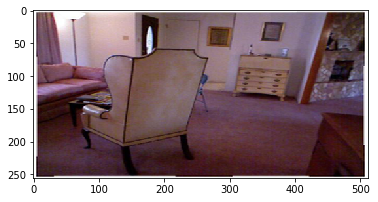

In [0]:
flipped_image = np.fliplr(input_image)

plt.imshow(flipped_image)
plt.show()

### Combine Images for Model Input

In [0]:
input_images = np.stack((input_image, flipped_image), 0)

input_images.shape

(2, 256, 512, 3)

In [16]:
import os

tf.reset_default_graph()

left  = tf.placeholder(tf.float32, [2, input_height, input_width, 3])
model = MonodepthModel(params, "test", left, None)

# SESSION
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)

# SAVER
train_saver = tf.train.Saver()

# INIT
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
coordinator = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coordinator)

# RESTORE
checkpoint_path = 'chkpts/model_kitti'
restore_path = checkpoint_path.split(".")[0]
train_saver.restore(sess, restore_path)

disp = sess.run(model.disp_left_est[0], feed_dict={left: input_images})


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


ValueError: The passed save_path is not a valid checkpoint: chkpts/model_kitti

In [ ]:
def post_process_disparity(disp):
    _, h, w = disp.shape
    l_disp = disp[0,:,:]
    r_disp = np.fliplr(disp[1,:,:])   # flip reversed image back to correct orientation
    m_disp = 0.5 * (l_disp + r_disp)  # find the mean of the two images
    l, _ = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp


In [ ]:
disp.shape

In [ ]:
np.array(np.meshgrid(np.linspace(0, 1, 512), np.linspace(0, 1, 256)))[0]

In [ ]:
np.array(np.meshgrid(np.linspace(0, 1, 512), np.linspace(0, 1, 256)))[1]

In [17]:
disp.squeeze().shape

NameError: name 'disp' is not defined

In [0]:
disp[0, :, :].shape

(256, 512, 1)

In [0]:
disp_pp = post_process_disparity(disp.squeeze()).astype(np.float32)

In [0]:
disp_pp = post_process_disparity(disp.squeeze()).astype(np.float32)

output_directory = os.path.dirname(image_path)
output_name = os.path.splitext(os.path.basename(image_path))[0]

np.save(os.path.join(output_directory, "{}_disp.npy".format(output_name)), disp_pp)
disp_to_img = scipy.misc.imresize(disp_pp.squeeze(), [original_height, original_width])
plt.imsave(os.path.join(output_directory, "{}_disp.png".format(output_name)), disp_to_img, cmap='plasma')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


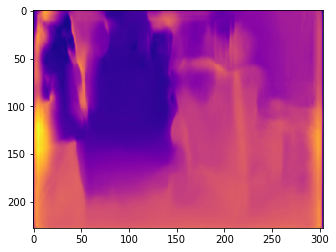

In [0]:
output_image = scipy.misc.imread('input_disp.png', mode="RGB")

plt.imshow(output_image)
plt.show()